# Inverse Folding with PoET-2 for Generation of Novel Luciferases

In this tutorial, we'll use PoET-2 to perform inverse folding - the task of designing novel protein sequences that adopt a desired three-dimensional structure.

**Objective** We'll use PoET-2 to generate novel small luciferases that:

- Fold into the same structure as the small luciferase from deep-sea shrimp *Oplophorus gracilirostris* (UniProt ID: LUCI_OPLGR). This constrains the *entire structure* of the proteins we generate.
- Preserve the amino acid identity of critical residues in the active site to maintain catalytic activity. This constrains *part of the sequence* of the proteins we generate.
- Have low sequence identity to known proteins, ensuring novelty.

**Why Luciferases?**
Luciferases catalyze bioluminescent reactions. These enzymes are invaluable in biotechnology applications including:

- Reporter gene assays
- In vivo imaging
- ATP detection
- Cell viability tests
- Protein interaction studies

Small luciferases are particularly of interest, because they are less likely to interfere with the subject being studied. However, the design of novel small luciferases is challenging because natural small luciferases have few or no known sequence homologs. Due to the lack of sequence homologs, we'll condition PoET-2 on *structural* homologs. PoET-2's in-context learning capabilities allow it to learn from these structural homologs to improve design success rates despite their low sequence identity to the target protein.

## Prerequisites

1. Download the necessary data

    1. Create the directory `data` in the working directory of this notebook, if it doesn't already exist.
    1. Download the file [PoET-2_inverse_folding_small_luc_example.zip](https://drive.google.com/file/d/1Fva12dY8_Mz-tiAJH5M5fAucE07eXfkz/view?usp=sharing). This file contains the sequences and structures used to create the prompt for PoET-2.
    1. Unzip the file in the `data` directory. You should end up with a new directory, `data/PoET-2_inverse_folding_small_luc_example`, located in the working directory of this notebook.

1. Install the necessary Python packages, including

    - `openprotein-python>=0.7.0`
    - `numpy`
    - `pandas`
    - `scipy`
    - `matplotlib`
    - `seaborn`

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gemmi

import openprotein
import openprotein.fasta as fasta
from openprotein.protein import Protein

DATA_DIR = Path("data/PoET-2_inverse_folding_small_luc_example")

## Define the prompt for PoET-2

To instruct PoET-2 to perform inverse folding, we need to construct a prompt that specifies the task. A prompt consists of two components:

- **Query**: A single, partially specified protein that defines explicit sequence and/or structure constraints for the target design. PoET-2 will complete the unspecified residues in the query sequence while preserving any provided constraints.
- **Context**: A set of proteins related to the target, which implicitly defines the relevant fitness landscape. In our case, since we're interested in generating sequences with structure similar to LUCI_OPLGR, the context will consist of its structural homologs.

### Define the query in Python

To specify the query, we'll use the `Protein` class, which represents a protein with both sequence and structure information. The `Protein` class is constructed from four main fields:

- `sequence`: the sequence of the protein
- `coordinates`: an array containing the 3D coordinates of the heavy atoms of the protein in atom37 format. It has shape `(L, 37, 3)`, where `L` is the length of the protein, `37` is the number of heavy atoms, and `3` is the number of coordinates (x, y, and z).
- `plddt`: an array of shape `(L,)`. For predicted structures, this contains the pLDDT of each residue, which is a measure of prediction confidence. For experimental structures, this should be set to `100` if the coordinates of the alpha carbon are known, and `NaN` otherwise.
- `name`: (optional) the name of the protein

We can easily create `Protein` objects from structure files using the helper function `Protein.from_filepath`. In this case, we'll use the file `8bo9.cif`, which contains the experimentally solved structure of NanoLuc<sup>CTZ</sup> (PDB ID: 8BO9), an optimized variant of LUCI_OPLGR with significantly higher luminescence when paired with the substrate CTZ.

In [2]:
structure_filepath = DATA_DIR / "structures" / "8bo9.cif"
query_protein = Protein.from_filepath(path=structure_filepath, chain_id="A")

Let's inspect the fields of our `query_protein` object to verify that the structure file was parsed correctly:

In [3]:
print("sequence:", query_protein.sequence)
print("coordinates shape:", query_protein.coordinates.shape)
print("plddt shape:", query_protein.plddt.shape)
print("name:", query_protein.name)

sequence: b'MHHHHHHSDNMVFTLEDFVGRWRQTAGYNLDQVLEQGGVSSLFQNLGVSVTPIQRIVLSGENGLKIDIAVIIPYEGLSGDQMGQIEKIFKVVYPVDDHHFRVILHYGTLVIDGVTPNMIDYFGRPYEGIAVFDGKKITVTGTLWNGNKIIDERLINPDGSLLFRVTINGVTGWRLCERILA'
coordinates shape: (181, 37, 3)
plddt shape: (181,)
name: 8bo9


We now have a `Protein` object representing the full sequence and structure of NanoLuc. Since our task is to redesign all the residues except the active site residues while preserving the overall protein structure, we'll mask out the sequence at all positions except the active site, while leaving the structure alone:

In [4]:
# NB: active site positions are 1-indexed
active_site_positions = np.array([30, 33, 34, 43, 52, 68, 70, 104, 106, 119, 121, 122, 126, 149, 151, 163, 165, 174])  # fmt: skip
# mask the sequence at all residues except at active site positons
query_protein = query_protein.mask_sequence_except_at(active_site_positions)

Inspecting the new query sequence, we see that masked residues are represented by the character `X`.

In [5]:
print("sequence:", query_protein.sequence)

sequence: b'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXLXXVLXXXXXXXXFXXXXXXXXPXXXXXXXXXXXXXXXIXVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLXYXXXXXXXXXXXXIXYFXXXYXXXXXXXXXXXXXXXXXXXXXXIXDXXXXXXXXXXXFXVXXXXXXXXRXXXXXXX'


Lastly, observe that the original, unmasked sequence has an "SDN" his-tag linker at the N-terminus; we don't need the model to generate this, so we remove it:

In [6]:
sdn_linker = b"MHHHHHHSDN"
query_protein = query_protein[len(sdn_linker):]
active_site_positions = active_site_positions - len(sdn_linker)
print("sequence:", query_protein.sequence)
print("length:", len(query_protein))

sequence: b'XXXXXXXXXXXXXXXXXXXLXXVLXXXXXXXXFXXXXXXXXPXXXXXXXXXXXXXXXIXVXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXLXYXXXXXXXXXXXXIXYFXXXYXXXXXXXXXXXXXXXXXXXXXXIXDXXXXXXXXXXXFXVXXXXXXXXRXXXXXXX'
length: 171


We have now created a query that defines the sequence and structure constraints on the protein we want to generate!

### Define the context in Python

Next, we create a context consisting of structural homologs of LUCI_OPLGR/NanoLuc, identified using [Foldseek](https://www.nature.com/articles/s41587-023-01773-0).

In this section, we demonstrate how to create a context from structure files and FASTA files containing the structures and sequences of the homologs. Below is a high-level overview of how these files were generated; code examples are provided in the Appendix of this notebook:

1. **Search for structural homologs**: Use Foldseek to search for structural homologs in two structure databases -  PDB and AlphaFoldDB (AFDB).
1. **Sample a diverse subset** from each database:

    1. Filter out sequences with high identity to LUCI_OPLGR/NanoLuc to encourage novelty.
    1. Create a multiple sequence alignment (MSA) of the remaining sequences.
    1. Compute pairwise sequence identities using the MSA.
    1. Perform hierarchical clustering using pairwise identity as the distance metric.
    1. Select a desired number of clusters and extract the cluster centroids as representative sequences.

1. **Combine results**: Merge the selected sequences and structures from both PDB and AFDB to form the final context.

The resulting context includes structural homologs from both PDB and AFDB. The PDB portion is composed of Protein objects instantiated directly from PDB structure files:

In [7]:
pdb_context_proteins: list[Protein] = []
# 1. The file `DATA_DIR / "context_pdb_chains.csv"` contains a list of PDB chains that are
#    structural homologs of LUCI_OPLGR/NanoLuc.
context_pdb_chains_df = pd.read_csv(DATA_DIR / "context_pdb_chains.csv")
# 2. The structure files of these PDB chains are already downloaded under `DATA_DIR / structures`.
#    We create Protein objects from these structure files, remove His tags, and add them to
#    pdb_context_proteins.
for pdb_id, chain_id in context_pdb_chains_df.itertuples(index=False):
    # create Protein object from structure file
    protein = Protein.from_filepath(
        DATA_DIR / "structures" / f"{pdb_id}.cif", chain_id=chain_id, verbose=False
    )
    # remove His tags from the protein
    his_tag = b"H" * 6
    while his_tag in protein.sequence:
        i = protein.sequence.index(his_tag)
        protein = protein[:i] + protein[i + len(his_tag) :]
    # add the protein to the context
    pdb_context_proteins.append(protein)
print("Number of homologs from PDB:", len(pdb_context_proteins))
print("Total length of proteins from PDB:", sum(len(p) for p in pdb_context_proteins))

Number of homologs from PDB: 100
Total length of proteins from PDB: 20174


For the AFDB portion of the context, we include only the sequences of the structural homologs, and not their predicted structures. While predicted structures can certainly be used in the context, we found them to be unnecessary in this case. Since structural information of these proteins isn't required, these homologs could be added to the context as simple byte strings or plain strings rather than `Protein` objects. However, we'll make use of `Protein` objects anyways, as `Protein` objects allow us to associate sequences with names, and the names may be helpful for us to quickly identify what proteins are in the context in the future:

In [8]:
afdb_context_proteins: list[Protein] = []
# 1. The file `DATA_DIR / "context_afdb_sequences.fasta"` contains the sequences of the
#    structural homologs of LUCI_OPLGR/NanoLuc found in AFDB
afdb_fasta_filepath = Path(DATA_DIR / "context_afdb_sequences.fasta")
# 2. We use the helper function `fasta.parse_stream` to parse the fasta file, and add
#    the sequences to the context as Protein objects
for name, sequence in fasta.parse_stream(afdb_fasta_filepath.open("rb")):
    afdb_context_proteins.append(Protein(sequence=sequence, name=name))
print("Number of homologs from AFDB:", len(afdb_context_proteins))
print("Total length of proteins from AFDB:", sum(len(p) for p in afdb_context_proteins))

Number of homologs from AFDB: 300
Total length of proteins from AFDB: 62007


Finally, we merge the contexts from each database into a single list, creating the final context.

In [9]:
context_proteins = pdb_context_proteins + afdb_context_proteins
print("Total homologs in context:", len(context_proteins))
print("Total length of proteins in context:", sum(len(p) for p in context_proteins))

Total homologs in context: 400
Total length of proteins in context: 82181


## Generate novel sequences via inverse folding with PoET-2

Now that we have a prompt (query and context) describing the sequence generation task, we can use PoET-2 to generate some novel and functional sequences!

### Connect to the OpenProtein.AI API

In [10]:
def get_session():
    with open("secrets.config", "r") as f:
        config = json.load(f)
    return openprotein.connect(config["username"], config["password"])


session = get_session()

### Create the prompt on the OpenProtein.AI server

The context and query are uploaded separately. First, we upload the context using the method `session.prompt.create_prompt`. For historical reasons, this method is called `create_prompt` rather than `create_context`.

In [11]:
# replace the following with an existing context_id to reuse an existing context
context_id: str | None = None
if context_id is None:
    context = session.prompt.create_prompt(
        context=context_proteins, name="PoET-2_inverse_folding_small_luc_example"
    )
else:
    context = session.prompt.get_prompt(context_id)
context

PromptMetadata(id='fea95f08-a14b-48d3-a760-d1883d83f0a6', name='PoET-2_inverse_folding_small_luc_example', description=None, created_date=datetime.datetime(2025, 5, 2, 2, 5, 54, 906266, tzinfo=TzInfo(UTC)), num_replicates=1, job_id=None, status=<JobStatus.SUCCESS: 'SUCCESS'>)

In [12]:
# replace the following with an existing query_id to reuse an existing query
query_id: str | None = None
if query_id is None:
    query = session.prompt.create_query(query=query_protein)
else:
    query = session.prompt.get_query(query_id)
query

QueryMetadata(id='467aed56-15c5-48d9-97d1-86e6d2958a0f', created_date=datetime.datetime(2025, 5, 2, 2, 5, 56, 621544, tzinfo=TzInfo(UTC)))

### Generate with PoET-2 using the prompt

Now let's use PoET-2 to generate some sequences! Here, we generate 100 sequences with a temperature of 0.3. Lower temperatures typically lead to sequences that better preserve structural constraints, though they may be less diverse. You may need to tune this parameter to achieve the desired diversity.

In [13]:
# replace the following with an existing job id to retrieve results for an existing job
generate_job_id: str | None = None
if generate_job_id is None:
    generate_job = session.embedding.poet_2.generate(
        # NB: for historical reasons, the parameter for context is named prompt
        prompt=context,
        query=query,
        num_samples=200,
        temperature=0.3,
    )
else:
    generate_job = session.load_job(generate_job_id)
print(generate_job)
_ = generate_job.wait_until_done(verbose=True)

num_records=200 job_id='d34d96b3-8793-42f0-9905-393c3c4063a6' job_type=<JobType.poet_generate: '/poet/generate'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2025, 5, 2, 2, 5, 57, 576760, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


Waiting: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s, status=SUCCESS]


We retrieve the generated sequences in a dataframe:

In [14]:
generated_seqs_df = pd.DataFrame(generate_job.get())
generated_seqs_df["score"] = generated_seqs_df["score"].apply(np.mean)
generated_seqs_df.head(3)

,name,sequence,score
0,generated-sequence-1,MKYTLEDFVGTWKMESSENLDEVLKELGLSMLFRKLANNISPTLVI...,-161.09839
1,generated-sequence-2,MKYTMEDFVGTWELVSSENLDEVLKALGLSFLFRKAANTVKPTLVV...,-170.81026
2,generated-sequence-3,MKFTVDDFVGTWKMESSENLDEVLEALGVSKLFRTLANKITPTLII...,-161.31497


In the next sections, we'll do some exploration of these sequences to validate their properties.

## Validate the novelty of the generated sequences

We validate the novelty of the generated sequences by computing their maximum sequence identity to wild-type (LUCI_OPLGR) and to sequences in the context. First, we define a function to compute sequence identity; it is not necessary to read the function definition:

In [15]:
def seqid_to_query(
    query: str,
    target: str,
    scoring: gemmi.AlignmentScoring | None = gemmi.AlignmentScoring("b"),
) -> float:
    result = gemmi.align_string_sequences(
        gemmi.expand_one_letter_sequence(query, gemmi.ResidueKind.AA),
        gemmi.expand_one_letter_sequence(target, gemmi.ResidueKind.AA),
        [],
        scoring,
    )
    return result.calculate_identity(1)

Now, we can use the function to compute and visualize the maximum sequence identities:

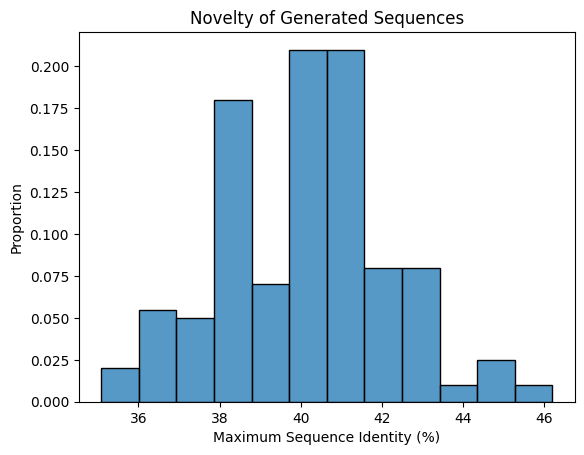

In [16]:
query_sequences = list(generated_seqs_df["sequence"])
# define the sequences we want to compare to
target_sequences = []
wt = Protein.from_filepath(path=structure_filepath, chain_id="A")[len(sdn_linker) :]
target_sequences.append(wt.sequence.decode())
for protein in context_proteins:
    target_sequences.append(protein.sequence.decode())
# compute the sequence identities
seqids = np.zeros((len(query_sequences), len(target_sequences)), dtype=np.float32)
for i, _query in enumerate(query_sequences):
    for j, _target in enumerate(target_sequences):
        seqids[i, j] = seqid_to_query(query=_query, target=_target)
# compute max sequence identities to targets
max_seqids = seqids.max(axis=1)
# visualize the max sequence identities
g = sns.histplot(max_seqids, stat="proportion")
_ = g.set_xlabel("Maximum Sequence Identity (%)")
_ = g.set_ylabel("Proportion")
_ = g.set_title("Novelty of Generated Sequences")

We see that our generated sequences are highly novel, with almost all sequence identities less than 50%, and some as low as ~35%! As additional validation, we should BLAST the generated sequences against a larger set of sequences such as UniProt, but low sequence identity to sequences in the context is generally a good indicator of novelty.

## Validate the diversity of generated sequences

Next, we check that the generated sequences have reasonable diversity between themselves. Like before, we compute the identities and visualize them:

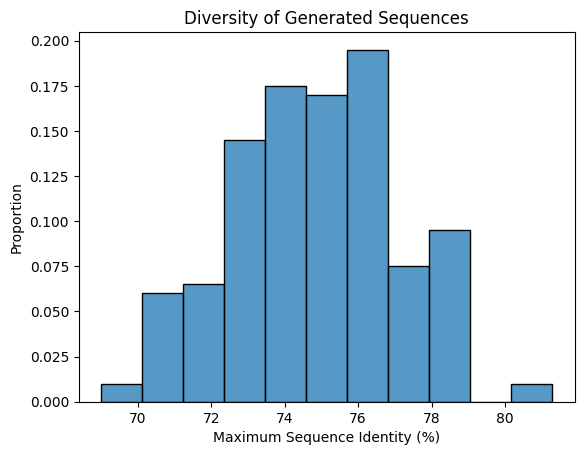

In [17]:
# compute the sequence identities
seqids = np.zeros((len(query_sequences), len(query_sequences)), dtype=np.float32)
for i, _query in enumerate(query_sequences):
    for j, _target in enumerate(query_sequences):
        if i == j:
            continue  # don't compute identity to self
        seqids[i, j] = seqid_to_query(query=_query, target=_target)
# compute max sequence identities
max_seqids = seqids.max(axis=1)
# visualize the max sequence identities
g = sns.histplot(max_seqids, stat="proportion")
_ = g.set_xlabel("Maximum Sequence Identity (%)")
_ = g.set_ylabel("Proportion")
_ = g.set_title("Diversity of Generated Sequences")

The graph verifies that the generated sequences are diverse, with sequence identities ranging between ~65% and ~80%.

## Validate the structures of generated sequences *in silico* with ESMFold

Before sending these sequences to the lab for testing, it’s important to evaluate them *in silico* to ensure they’re predicted to fold into a structure similar to our target. For this, we'll use ESMFold, which offers fast structure predictions with accuracy comparable to AlphaFold2.

In addition to folding the generated sequences, we'll also fold the wild-type sequence to establish a baseline for how well ESMFold can fold sequences that are already known to fold into our desired structure:

In [18]:
sequences_to_fold = [wt.sequence] + list(generated_seqs_df["sequence"])

# replace the following with an existing job id to retrieve results for an existing job
fold_job_id: str | None = None
if fold_job_id is None:
    fold_job = session.fold.esmfold.fold(sequences_to_fold)
else:
    fold_job = session.load_job(fold_job_id)
print(fold_job)
_ = fold_job.wait_until_done(verbose=True)

num_records=201 job_id='51462fc1-a3bc-4ee3-8656-8dbf9fd8ef31' job_type=<JobType.embeddings_fold: '/embeddings/fold'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2025, 5, 2, 2, 7, 29, 624696, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


Waiting: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it, status=SUCCESS]


We retrieve the predicted structures in a dataframe:

In [19]:
fold_df = pd.DataFrame(fold_job.get(), columns=["sequence", "pdb_as_string"])
fold_df["sequence"] = fold_df["sequence"].astype(str)
fold_df.head(1)

,sequence,pdb_as_string
0,MVFTLEDFVGRWRQTAGYNLDQVLEQGGVSSLFQNLGVSVTPIQRI...,b'PARENT N/A\nATOM 1 N MET A 1 ...


To measure the accuracy of the wild-type structure prediction, we compute four metrics

- `rmsd`: the root mean square deviation (RMSD) of the backbone atoms versus the same atoms in the experimental structure
- `plddt`: the average pLDDT of the predicted structure
- `active_site_rmsd`: the RMSD of all heavy atoms in the active site versus the same atoms in the experimental structure
- `active_site_plddt`: the average pLDDT of the predicted active site

In [20]:
# the predicted structure of wild-type should be the first row of fold_df
row = fold_df.iloc[0]
assert row["sequence"] == wt.sequence.decode()
# construct a `Protein` object from the predicted structure, and use its helper methods
# to compute the metrics
wt_predicted = Protein.from_string(row["pdb_as_string"], format="pdb", chain_id="A")
wt_rmsd = wt_predicted.rmsd(tgt=wt, backbone_only=True)
wt_plddt = wt_predicted.plddt.mean()
wt_active_site_rmsd = wt_predicted.at(active_site_positions).rmsd(
    tgt=wt.at(active_site_positions)
)
wt_active_site_plddt = wt_predicted.at(active_site_positions).plddt.mean()
# print out the metrics
print(f"{wt_rmsd=:.5f}")
print(f"{wt_plddt=:.5f}")
print(f"{wt_active_site_rmsd=:.5f}")
print(f"{wt_active_site_plddt=:.5f}")

wt_rmsd=1.12560
wt_plddt=84.50854
wt_active_site_rmsd=1.98245
wt_active_site_plddt=82.11166


Based on these metric values, we conclude that ESMFold can fold the wild-type sequence with reasonable accuracy (the values are somewhat lower than ideal, but this is to be expected as this protein has few sequence homologs).

Next, we compute the same metrics for the generated sequences.

In [21]:
# first, we create a single dataframe containing the generated sequences and predicted structures
generated_df = generated_seqs_df.merge(fold_df, on="sequence", validate="1:1")
print(f"{len(generated_df)=}")
generated_df.head(1)

len(generated_df)=200


,name,sequence,score,pdb_as_string
0,generated-sequence-1,MKYTLEDFVGTWKMESSENLDEVLKELGLSMLFRKLANNISPTLVI...,-161.09839,b'PARENT N/A\nATOM 1 N MET A 1 ...


In [22]:
# next, we create a new dataframe containing the metrics for the generated sequences
generated_stats_records = []
for _, sequence, score, pdb_as_string in generated_df.itertuples(index=False):
    predicted = Protein.from_string(pdb_as_string, format="pdb", chain_id="A")
    generated_stats_records.append(
        {
            "sequence": sequence,
            "score": score,
            "rmsd": predicted.rmsd(tgt=wt, backbone_only=True),
            "plddt": predicted.plddt.mean(),
            "active_site_rmsd": predicted.at(active_site_positions).rmsd(
                tgt=wt.at(active_site_positions)
            ),
            "active_site_plddt": predicted.at(active_site_positions).plddt.mean(),
        }
    )
generated_stats_df = pd.DataFrame.from_records(generated_stats_records)
generated_stats_df.head(1)

,sequence,score,rmsd,plddt,active_site_rmsd,active_site_plddt
0,MKYTLEDFVGTWKMESSENLDEVLKELGLSMLFRKLANNISPTLVI...,-161.09839,2.033154,83.62796,2.045822,83.161667


In [23]:
# examine the summary statistics of the metrics
generated_stats_df.describe()

,score,rmsd,plddt,active_site_rmsd,active_site_plddt
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-161.557205,1.682657,81.573135,2.013412,81.506081
std,6.624926,0.876068,3.106332,0.329494,3.291832
min,-176.877840,1.020650,70.084328,1.295836,71.670006
25%,-165.500493,1.341585,80.033382,1.767642,79.437918
50%,-162.436260,1.521111,81.603745,1.955735,81.613064
75%,-159.069680,1.714166,83.503099,2.225503,83.598186
max,-135.649870,9.122282,90.515900,3.334953,91.263329


We visualize the metrics to examine their distribution and compare them to the metrics for wild-type:

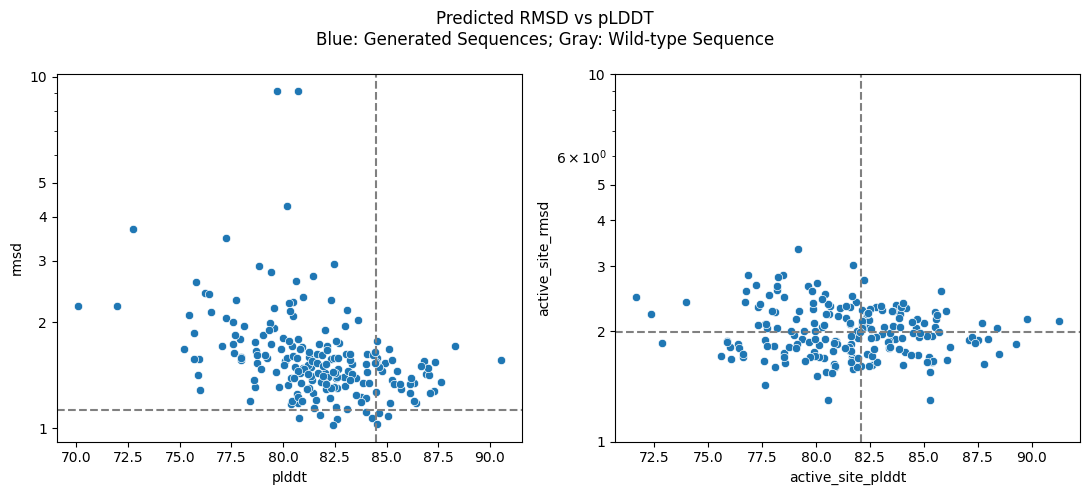

In [24]:
f, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.scatterplot(data=generated_stats_df, x="plddt", y="rmsd", ax=axes[0])
sns.scatterplot(
    data=generated_stats_df, x="active_site_plddt", y="active_site_rmsd", ax=axes[1]
)
for ax, plddt, rmsd in zip(
    axes, (wt_plddt, wt_active_site_plddt), (wt_rmsd, wt_active_site_rmsd)
):
    ax.set_yscale("log")
    ax.set_yticks([1, 2, 3, 4, 5, 10], [1, 2, 3, 4, 5, 10])
    ax.axvline(plddt, color="gray", ls="--")
    ax.axhline(rmsd, color="gray", ls="--")
f.suptitle(
    "Predicted RMSD vs pLDDT\nBlue: Generated Sequences; Gray: Wild-type Sequence"
)
f.tight_layout()

From the graphs, we see that the majority of generated sequences have low RMSD (<2Å) to the target structure while also exhibiting high confidence (pLDDT > 80). Notably, some generated sequences yield predicted structures that are both more confident and more similar to the experimentally determined target than the wild-type, especially in the functionally critical active site.

These results suggest that the generated sequences are likely to fold into the desired structure! To further improve our success rate, we may remove sequences with high RMSDs and low pLDDTs. If we need more sequences after filtering, we can easily generate more using the workflow outlined above.

## Conclusion

In this walkthrough, we demonstrated how to use PoET-2 to perform inverse folding, and how to validate the generated sequences *in silico*. Despite the challenge posed by a target with few sequence homologs, PoET-2 successfully generated sequences predicted to fold into the target structure with high accuracy and confidence. We’re excited to see what sequences you design with PoET-2 - and how you apply it to your own protein design challenges!

# Appendix

## Creating a context containing structural homologs

This section provides code examples demonstrating how to find and sample the diverse structural homologs used to create the context in the "Create the context" section above. In the next cell, we define a bunch of helper functions; it's not necessary to read them:

In [25]:
import io
import requests
import time
import tarfile
from concurrent.futures import ThreadPoolExecutor

import numpy.typing as npt

import scipy
from scipy.spatial.distance import pdist, squareform

from tqdm import tqdm


def run_foldseek(
    query_filepath: Path | str, output_dir: Path, verbose: bool = False
) -> tuple[Path, Path]:
    pdb_result_path = output_dir / "alis_pdb100.m8"
    afdb_result_path = output_dir / "alis_afdb50.m8"
    if pdb_result_path.is_file() and afdb_result_path.is_file():
        return pdb_result_path, afdb_result_path
    output_dir.mkdir(parents=True, exist_ok=True)

    query = Path(query_filepath).read_text()
    databases = ("afdb50", "pdb100")
    mode = "3diaa"
    iterative = False
    ticket = requests.post(
        "https://search.foldseek.com/api/ticket",
        {
            "q": query,
            "database[]": list(databases),
            "mode": mode,
            "iterativesearch": str(iterative).lower(),
        },
    ).json()
    if "id" not in ticket:
        raise ValueError(ticket)
    ticket_id = ticket["id"]
    if verbose:
        print(f"Got ticket: {ticket_id}")

    count = 0
    while True:
        status = requests.get(
            f"https://search.foldseek.com/api/ticket/{ticket_id}"
        ).json()["status"]
        if status == "ERROR":
            raise ValueError(query)
        elif status == "COMPLETE":
            break
        else:
            time.sleep(1)
            count += 1
    if verbose:
        print(f"Ticket {ticket_id} completed in: {count}s")

    download = requests.get(
        f"https://search.foldseek.com/api/result/download/{ticket_id}", stream=True
    )
    file_bytes = io.BytesIO()
    for chunk in download.iter_content(chunk_size=8192):
        file_bytes.write(chunk)
    file_bytes.seek(0)

    with tarfile.open(fileobj=file_bytes, mode="r:gz") as tar:
        for member in tar.getmembers():
            if member.name not in ("alis_afdb50.m8", "alis_pdb100.m8"):
                continue
            extracted_file = tar.extractfile(member)
            assert extracted_file is not None
            with (output_dir / member.name).open("wb") as out_file:
                out_file.write(extracted_file.read())
    return pdb_result_path, afdb_result_path


def foldseek_pdb_result_to_dataframe(path: Path | str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", header=None)
    return pd.DataFrame(
        {
            "pdb_id": df[1].apply(lambda x: x.split()[0][:4]),
            "chain_id": df[1].apply(lambda x: x.split()[0].split("_")[1].split("-")[0]),
            "sim": df[2],
            "sequence": df[18],
            "species": df[20],
        }
    ).drop_duplicates(["pdb_id", "chain_id"])


def foldseek_afdb_result_to_dataframe(path: Path | str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", header=None)
    return pd.DataFrame(
        {"name": df[1], "sim": df[2], "sequence": df[18], "species": df[20]}
    ).drop_duplicates(["sequence"])


def run_openprotein_mafft_alignment(
    sequences: list[bytes | str],
    names: list[str] | None,
    output_path: Path | str,
    verbose: bool = False,
) -> Path:
    # return existing filepath if it already exists
    output_path = Path(output_path)
    if output_path.is_file():
        return output_path
    output_path.parent.mkdir(parents=True, exist_ok=True)
    # otherwise run mafft, write result to disk, and return the filepath
    session = get_session()
    mafft_job = session.align.mafft(sequences=sequences, names=names)
    mafft_job.wait_until_done(verbose=verbose)
    with output_path.open("wb") as fp:
        for name, sequence in mafft_job.get():
            fp.write(b">" + name.encode() + b"\n")
            fp.write(sequence.encode() + b"\n")
    return output_path


def compute_n_eff(
    alignment_path: Path | str,
    identity: float = 50.0,
    min_length: int | None = None,
    max_length: int | None = None,
) -> float:
    # Read alignment
    with Path(alignment_path).open("rb") as f:
        _, prompt_seqs = fasta.parse(f)
    prompt_seqs = np.array(prompt_seqs)
    # Get unique sequences
    prompt_seqs = np.unique(prompt_seqs)
    # Convert sequences to numpy arrays
    prompt_seqs = np.stack(
        [np.frombuffer(s, dtype=np.uint8) for s in prompt_seqs], axis=0
    )
    # Filter by max length
    if min_length is not None or max_length is not None:
        min_length = min_length or 0
        max_length = max_length or 2**32
        lengths = (prompt_seqs != ord(b"-")).sum(axis=-1)
        keep = (lengths >= min_length) & (lengths <= max_length)
        prompt_seqs = prompt_seqs[keep]
    # Compute percent identities
    is_gap = prompt_seqs == ord(b"-")
    one_not_gap = ~(is_gap & is_gap[:, np.newaxis])
    is_match = prompt_seqs == prompt_seqs[:, np.newaxis]
    is_match[~one_not_gap] = (
        False  # don't count positions where both sequences have gaps
    )
    num_not_gap = one_not_gap.sum(axis=-1)
    num_match = is_match.sum(axis=-1)
    pid = num_match / num_not_gap
    weights = (pid >= (identity / 100)).sum(axis=1)
    return float(np.sum(1 / weights))


def sample_n_from_alignment(
    alignment_path: Path | str,
    n: int,
    min_length: int | None = None,
    max_length: int | None = None,
) -> npt.NDArray[np.integer]:
    # Read alignment
    with Path(alignment_path).open("rb") as f:
        _, prompt_seqs = fasta.parse(f)
    names = np.arange(len(prompt_seqs))
    prompt_seqs = np.array(prompt_seqs)
    # Get unique sequences
    prompt_seqs, uind = np.unique(prompt_seqs, return_index=True)
    names = names[uind]
    # Convert sequences to numpy arrays
    prompt_seqs = np.stack(
        [np.frombuffer(s, dtype=np.uint8) for s in prompt_seqs], axis=0
    )
    # Filter by max length
    if min_length is not None or max_length is not None:
        min_length = min_length or 0
        max_length = max_length or 2**32
        lengths = (prompt_seqs != ord(b"-")).sum(axis=-1)
        keep = (lengths >= min_length) & (lengths <= max_length)
        prompt_seqs = prompt_seqs[keep]
        names = names[keep]
    # Perform hierarchical clustering on sequences
    dist = pdist(prompt_seqs, metric="hamming")
    Z = scipy.cluster.hierarchy.average(dist)
    # Sample n clusters
    clusters = scipy.cluster.hierarchy.cut_tree(Z, n)
    # Take the centroid of each cluster
    prompt = []
    prompt_names = []
    for c in range(n):
        loc = clusters[:, 0] == c
        cluster_seqs = prompt_seqs[loc]
        cluster_names = names[loc]
        cluster_dist = squareform(dist)[loc, :][:, loc]
        avg_dist = cluster_dist.mean(axis=1)
        i = np.argmin(avg_dist)  # get the centroid
        s = cluster_seqs[i]
        name = cluster_names[i]
        prompt.append(s)
        prompt_names.append(name)
    prompt = np.stack(prompt, axis=0)
    prompt_names = np.array(prompt_names)
    return prompt_names


def download_pdb_structures(pdb_ids: list[str], output_dir: Path | str):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    def _download_pdb_structure(pdb_id: str):
        output_path = output_dir / f"{pdb_id.lower()}.cif"
        if output_path.is_file():
            return
        url = "https://files.rcsb.org/view/" + pdb_id.lower() + ".cif"
        response = requests.get(url)
        if response.status_code != 200:
            raise ValueError(pdb_id)
        output_path.write_bytes(response.content)

    with ThreadPoolExecutor() as executor:
        futures = []
        for pdb_id in pdb_ids:
            future = executor.submit(_download_pdb_structure, pdb_id)
            futures.append(future)
        for future in tqdm(futures):
            future.result()

The headers for the rest of this section will follow the steps outlined in the "Create the context" section.

### Step 1: Search for structural homologs

To run [Foldseek](https://www.nature.com/articles/s41587-023-01773-0) to find structural homologs, we can use the `run_foldseek` helper function. This function accepts an input structure file, searches for structural homologs in PDB and AFDB, and writes the result to the specified output directory.

**NOTE**: `run_foldseek` uses the public Foldseek server which is **not** operated by OpenProtein. Exercise caution when working with private structure files that are not meant to be public.

In [26]:
foldseek_pdb_result_path, foldseek_afdb_result_path = run_foldseek(
    # NB: 7snt.cif contains the structure of a NanoLuc, a variant of LUCI_OPLGR
    query_filepath=DATA_DIR / "structures" / "7snt.cif",
    output_dir=DATA_DIR / "foldseek" / "7snt",
    verbose=True,
)
print(f"{foldseek_pdb_result_path=}")
print(f"{foldseek_afdb_result_path=}")

foldseek_pdb_result_path=PosixPath('data/PoET-2_inverse_folding_small_luc_example/foldseek/7snt/alis_pdb100.m8')
foldseek_afdb_result_path=PosixPath('data/PoET-2_inverse_folding_small_luc_example/foldseek/7snt/alis_afdb50.m8')


`run_foldseek` returns the paths to two files. Each file is a BLAST formatted file listing structural homologs found by Foldseek. The first file contains hits found in PDB, and the second file contains hits found in AFDB.

Since the public Foldseek server is not deterministic, for the remainder of this example, we'll use the following precomputed Foldseek result files:

In [27]:
foldseek_pdb_result_path = DATA_DIR / "precomputed_foldseek_7snt_pdb100.m8"
foldseek_afdb_result_path = DATA_DIR / "precomputed_foldseek_7snt_afdb50.m8"

### Step 2: Sample a diverse subset (from PDB)

We process the Foldseek result file for hits found in PDB first.

#### Step 2.1: Filter out sequences with high identity to LUCI_OPLGR/NanoLuc to encourage novelty

In [28]:
# read the Foldseek result file for PDB
foldseek_pdb_result_df = foldseek_pdb_result_to_dataframe(foldseek_pdb_result_path)
print(f"{len(foldseek_pdb_result_df)=}")
foldseek_pdb_result_df.head()

len(foldseek_pdb_result_df)=399


,pdb_id,chain_id,sim,sequence,species
0,7snt,A,100.0,MVFTLEDFVGDWRQTAGYNLDQVLEQGGVSSLFQNLGVSVTPIQRI...,Oplophorus gracilirostris
1,7vsx,A,90.5,EFFTLEDFVGDWRQTAGYNQDQVLEQGGLSSLFQNLGVSVTPIQRI...,Oplophorus gracilirostris
2,7snt,B,87.9,MVFTLEDFVGDWRQTAGYNLDQVLEQGGVSSLFQGVSVTPIQRIVL...,Oplophorus gracilirostris
3,8bo9,B,91.1,NMVFTLEDFVGRWRQTAGYNLDQVLEQGGVSSLFQNLGVSVTPIQR...,synthetic construct
4,5b0u,B,91.7,EFFTLEDFVGDWRQTAGYNLDQVLEQGGVSSLFQNLGVSVTPIQRI...,Oplophorus gracilirostris


In [29]:
# filter out sequences with high identity (>= 70%)
foldseek_pdb_result_df = foldseek_pdb_result_df[foldseek_pdb_result_df["sim"] < 70]
print(f"{len(foldseek_pdb_result_df)=}")

len(foldseek_pdb_result_df)=385


#### Step 2.2: Create a multiple sequence alignment (MSA) of the remaining sequences

To create an MSA, we can use the helper function `run_openprotein_mafft_alignment`, which uses OpenProtein's REST API to compute an MSA using MAFFT. This function accepts a list of sequences to align, and writes the resulting MSA to the specified filepath:

In [30]:
foldseek_pdb_alignment_path = run_openprotein_mafft_alignment(
    sequences=list(foldseek_pdb_result_df["sequence"]),
    names=list(
        foldseek_pdb_result_df["pdb_id"] + "_" + foldseek_pdb_result_df["chain_id"]
    ),
    output_path=DATA_DIR / "MSAs" / "foldseek_7snt_pdb_result.fasta",
    verbose=True,
)
print(f"{foldseek_pdb_alignment_path=}")

foldseek_pdb_alignment_path=PosixPath('data/PoET-2_inverse_folding_small_luc_example/MSAs/foldseek_7snt_pdb_result.fasta')


Once again, to ensure that the remainder of this example is deterministic, we'll use a precomputed MSA:

In [31]:
foldseek_pdb_alignment_path = DATA_DIR / "precomputed_foldseek_7snt_pdb_result.fasta"

#### Steps 2.3, 2.4, and 2.5: Use the MSA to perform hierarchical clustering, and sample diverse sequences using the clustering

For convenience, the full text of each step is reproduced below:

- 2.3: Compute pairwise sequence identities using the MSA.
- 2.4: Perform hierarchical clustering using pairwise identity as the distance metric.
- 2.5: Select a desired number of clusters and extract the cluster centroids as representative sequences.

Before we perform sampling, we need to determine the number of sequences to sample. We do this by computing the number of effective sequences (N<sub>eff</sub>) at 50% identity using the helper function `compute_n_eff`. We also limit the maximum sequence length to 500, since the sequence we want to generate only has length 171.

In [32]:
foldseek_pdb_n_eff = compute_n_eff(
    foldseek_pdb_alignment_path, identity=50, max_length=500
)
foldseek_pdb_n_eff

98.73192556728901

N<sub>eff</sub> is about 100, so we'll sample that many sequences.

The three substeps (Steps 2.3, 2.4, and 2.5) can be performed with the function `sample_n_from_alignment`.

In [33]:
foldseek_pdb_sampled_idxs = sample_n_from_alignment(
    foldseek_pdb_alignment_path, n=100, max_length=500
)
print(len(foldseek_pdb_sampled_idxs))

100


The function returns a list of indices of the sequences in the MSA that should be included in our sample. Since the sequences in the MSA were obtained from the dataframe `foldseek_pdb_result_df`, we can index that dataframe to obtain the final set of sample sequences and their corresponding metadata:

In [34]:
foldseek_pdb_result_df = foldseek_pdb_result_df.iloc[foldseek_pdb_sampled_idxs]
foldseek_pdb_result_df.head()

,pdb_id,chain_id,sim,sequence,species
245,5xnw,A,20.0,MQARALQDLFDAQGVGVPVEHALRMQAVARQTNTVFGIRPVERIVT...,Pseudomonas aeruginosa
248,3ge2,A,16.3,QPVAQPTDIDGTYTGQDDGDRITLVVTGTTGTWTELESDGDQKVKQ...,Streptococcus pneumoniae TIGR4
249,5xi9,A,13.2,HMGDKSENVQDLLLLDVAPLSLGLETAGGVMTALIKRNSTIPTKQT...,Homo sapiens
258,5e86,A,13.4,DVCPLTLGIETVGGVMTKLIPRNTVVPTKKSQIFSVGGTVTIKVYE...,Homo sapiens
568,3qnj,B,9.1,VLLLDVTPLSLGIETMGGVMTTLIAKNTTIPTKHSQVFSTAEDNQS...,Escherichia coli K-12


Recall that the dataframe `context_pdb_chains_df` contains the pdb ids and chain ids of the PDB structures used in the context in our small luciferase inverse folding example. Let's verify that the pdb ids and chain ids in `foldseek_pdb_result_df` match those in `context_pdb_chains_df`:

In [35]:
assert (
    foldseek_pdb_result_df[["pdb_id", "chain_id"]]
    .reset_index(drop=True)
    .equals(context_pdb_chains_df)
)
print("Success! The pdb ids and chain ids in the two dataframes match!")

Success! The pdb ids and chain ids in the two dataframes match!


Lastly, we download the structure files of the sampled sequences from the PDB:

In [36]:
download_pdb_structures(
    pdb_ids=list(foldseek_pdb_result_df["pdb_id"]), output_dir=DATA_DIR / "structures"
)

100%|██████████| 100/100 [00:00<00:00, 88580.87it/s]


### Step 2: Sample a diverse subset (from AFDB)

Next, we process the Foldseek result file for hits found in AFDB. The process is essentially the same as processing the result file for PDB, with only minor adjustments. We show the code below, and make note of any adjustments.

#### Step 2.1: Filter out sequences with high identity to LUCI_OPLGR/NanoLuc to encourage novelty

This step is the same as when processing PDB hits, except that we use the function `foldseek_afdb_result_to_dataframe` instead of `foldseek_pdb_result_to_dataframe` to read the results into a dataframe.

In [37]:
foldseek_afdb_result_df = foldseek_afdb_result_to_dataframe(foldseek_afdb_result_path)
print(f"{len(foldseek_afdb_result_df)=}")
foldseek_afdb_result_df.head()

len(foldseek_afdb_result_df)=1368


,name,sim,sequence,species
0,AF-Q9GV45-F1-model_v4 Oplophorus-luciferin 2-m...,82.1,MAYSTLFIIALTAVVTQASSTQKSNLTFTLADFVGDWQQTAGYNQD...,Oplophorus gracilirostris
1,AF-A0A6V7X7K0-F1-model_v4 Hypothetical protein,18.9,MADKFVGKWKLTDSDNFNDYMKEVGVGMLARTGAAAVKPVLEFVVD...,Meloidogyne enterolobii
2,AF-F6W8U8-F1-model_v4 FABP domain-containing p...,16.6,MAKAVAGNWTLDRSENYDDFLKAAGMNSIKRAMAVKLGGSLSIENV...,Ciona intestinalis
3,AF-A0A267EGP2-F1-model_v4 FABP domain-containi...,20.1,MSTFEGKWQMTSSENFDAYMKALGTSFLVRKAAAAATPVQDIRCHG...,Macrostomum lignano
4,AF-C4N147-F1-model_v4 Sodium/calcium exchanger...,17.1,MAADLAGKWILESSENFDDYMKAVGVGMVMRKMANAATPTQEIKID...,Doryteuthis pealeii


In [38]:
# filter out sequences with high identity (>= 70%)
foldseek_afdb_result_df = foldseek_afdb_result_df[foldseek_afdb_result_df["sim"] < 70]
print(f"{len(foldseek_afdb_result_df)=}")

len(foldseek_afdb_result_df)=1367


#### Step 2.2: Create a multiple sequence alignment (MSA) of the remaining sequences

In [39]:
foldseek_afdb_alignment_path = run_openprotein_mafft_alignment(
    sequences=list(foldseek_afdb_result_df["sequence"]),
    names=list(foldseek_afdb_result_df["name"]),
    output_path=DATA_DIR / "MSAs" / "foldseek_7snt_afdb_result.fasta",
    verbose=True,
)
print(f"{foldseek_afdb_alignment_path=}")

foldseek_afdb_alignment_path=PosixPath('data/PoET-2_inverse_folding_small_luc_example/MSAs/foldseek_7snt_afdb_result.fasta')


In [40]:
foldseek_afdb_alignment_path = DATA_DIR / "precomputed_foldseek_7snt_afdb_result.fasta"

#### Steps 2.3, 2.4, and 2.5: Use the MSA to perform hierarchical clustering, and sample diverse sequences using the clustering

When processing AFDB hits, we set a stricter filter by length (min length 100 and max length 300 instead of simply max length 500) because there are many more AFDB hits, so we can impose a stricter filter while retaining lots of sequence data.

In [41]:
foldseek_afdb_n_eff = compute_n_eff(
    foldseek_afdb_alignment_path, identity=50, min_length=100, max_length=300
)
foldseek_afdb_n_eff

762.8258143602184

Even with the stricter sequence length filter, N<sub>eff</sub> is much larger for AFDB hits than PDB hits (by a factor of >7). Since it is generally not necessary to use PoET-2 with so many sequences in the context, and very large contexts makes inference slow, we sample just 300 sequences from the AFDB hits, instead of N<sub>eff</sub>=~763 hits.

In [42]:
foldseek_afdb_sampled_idxs = sample_n_from_alignment(
    foldseek_afdb_alignment_path, n=300, min_length=100, max_length=300
)
print(len(foldseek_afdb_sampled_idxs))

300


In [43]:
foldseek_afdb_result_df = foldseek_afdb_result_df.iloc[foldseek_afdb_sampled_idxs]
foldseek_afdb_result_df.head()

,name,sim,sequence,species
1835,AF-A0A7J9FSS2-F1-model_v4 Uncharacterized protein,5.4,MVSLVITRNIFRLLYAYTTSLSIRCLQVATGQVASTGMVALSYVQK...,Gossypium trilobum
602,AF-A0A348WGM0-F1-model_v4 DUF490 domain-contai...,11.5,SDPEITFTSDPDLPQDEVIARLIFGRGIDSISAFQAAQLASAVATL...,Roseovarius nubinhibens
362,AF-A0A3D0H8P6-F1-model_v4 Uncharacterized protein,14.8,VESLLAQAKEQWDSDPAKAQKLLEQALSLDPNHFDAVMQLGRLLTV...,Syntrophobacteraceae bacterium
1896,AF-A0A5D2CRZ8-F1-model_v4 Uncharacterized protein,9.8,MADVIYHAMSFVDLQFPNGQLTYVSYEGLTTSAFLPLCGGLLQAQG...,Gossypium darwinii
909,AF-A0A645C051-F1-model_v4 Plastocyanin-like do...,7.2,METNVIEFEAKTDGDWFFHCHILYHMMAGMNRVFAVGDYQNPLLPD...,bioreactor metagenome


Let's verify that the sampled sequences match the sequences in the AFDB context:

In [44]:
assert {s.encode() for s in foldseek_afdb_result_df["sequence"]} == {
    p.sequence for p in afdb_context_proteins
}
print("Success! The sampled sequences and the sequences in the AFDB context match!")

Success! The sampled sequences and the sequences in the AFDB context match!


Since we didn't use structures for the AFDB hits, we don't need to download them.

### Conclusion

We’ve now seen how to programmatically sample a diverse set of structural homologs to build a context for PoET-2. As with other forms of prompt engineering, designing the optimal context—choosing which sequences and structures to include—is both a science and an art. Don’t hesitate to experiment with alternative homology search methods and sampling strategies to suit your specific goals!